# Chapter 07 합성곱 신경망(CNN)

In [2]:
import numpy as np

CNN은 이미지 인식과 음성 인식 등 다양한 곳에서 사용된다.

## 7.1 전체 구조

**합성곱 계층** convolutional layer과 **풀링 계층** pooling layer가 있다.

이전의 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있었다. 이를 **완전연결**(fully connected) 이라고 하며, 완전히 연결된 계층을 **Affine 계층** 이라고 하였다.

<img src='./deep_learning_images/fig 7-1.png' width=70%>
<center>**그림 7-1** 완전연결 계층(Affine 계층)으로 이뤄진 네트워크의 예</center>

[그림 7-1]과 같은 완전연결 신경망은 Affine 계층 뒤에 *활성화 함수*를 갖는 ReLU 계층(혹은 Sigmoid 계층)이 이어진다. 이 그림에서는 Affine-ReLU 조합이 4개가 쌓였고, 마지막 5번째 층은 Affine 계층에 이어 소프트맥스 계층에서 최종 결과(확률)을 출력한다.

반면 CNN은 아래와 같이 다르다.

<img src='./deep_learning_images/fig 7-2.png' width=70%>
<center> CNN으로 이뤄진 네트워크의 예: 합성곱 계층과 풀링 계층이 새로 추가(회색)</center>

위처럼 CNN에서는 새로운 '합성곱 계층(Conv)'와 '풀링 계층(Pooling)'이 추가된다. (풀링 계층이 생략되기도 한다.) 'Affile-Relu'연결이 'Conv-ReLU-(Pooling)'으로 바뀌었다고 생각할 수 있다. 주목할 점은 출력에 가까운 층에서는 그대로 'Affine-ReLU' 구성을 그대로 사용할 수 있다는 점과 마지막 출력 계층에서는 'Affine-Softmax'조합을 그대로 사용한다는 점이다. CNN에서 흔히 볼 수 있는 구성이다.

## 7.2 합성곱 계층

CNN에서는 **패딩**(padding), **스트라이드**(stride)등 CNN 고유의 용어가 등장한다. 또, 각 계층 사이에는 3차원 데이터 같이 입체적인 데이터가 흐른다는 점에서 완전연결 신경망과 다르다.

### 7.2.1 완전연결 계층의 문제점

완전연결 계층에서는 인접하는 계층의 뉴런이 모두 연결되고 출력의 수는 임의로 정할 수 있었다.

**이는 '데이터의 형상이 무시' 된다는 문제점이 있다.** 가령 입력 데이터가 이미지라면 세로·가로·채널(색상)으로 구성된 3차원 데이터이다. 그러나 완전연결 계층에 입력할 때는 3차원 데이터를 평평한 1차원 데이터로 평탄화해 주어야 한다. 가령 이전 MNIST를 사용한 사례에서는 형상이 (1, 28, 28)인 이미지(1채널, 세로 28픽셀, 가로 28픽셀)를 1줄로 세운 784개의 데이터를 첫 Affine 계층에 입력했다.

이미지는 3차원 형상이며 이 형상에 중요한 정보가 있다. 가령 공간적으로 가까운 픽셀은 값이 비슷하거나, RBG의 각 체널은 서로 밀접하게 연관되어 있거나, 거리가 먼 픽셀끼리는 별 연관이 없는 등, 3차원 속에서의 의미를 갖는 본질적인 패턴이 숨어 있을 것이다. 하지만 완전연결 계층은 형상을 무시하고 모든 입력 데이터를 동등한 뉴런(같은 차원의 뉴런)으로 취급하여 형상에 담긴 정보를 살릴 수 없다.

반면 합성곱 계층은 형상을 유지한다. 이미지도 3차원 데이터로 입력받으며, 마찬가지로 다음 계층에도 3차원 데이터로 전달한다. 그래서 CNN에서는 이미지처럼 형상을 가진 데이터를 제대로 이해할 (가능성이 있는) 것이다.

CNN에서는 합성곱 계층의 입출력 데이터를 **특징 맵**(feature map)이라고 한다. 합성곱 계층의 입력 데이터를 **입력 특징 맵**(input feature map), 출력 데이터를 **출력 특징 맵**(output feature map)이라고 한다.

### 7.2.2 합성곱 연산

합성곱 계층에서의 **합성곱 연산**을 처리한다. 이는 이미지 처리에서 말하는 **필터 연산**에 해당한다.

<img src='./deep_learning_images/fig 7-3.png' width=70%>
<center> **그림7-3** 합성곱 연산의 예: 합성곱 연산을 $\bigotimes$ 기호로 표기</center>

입력 데이터는 세로·가로 방향의 형상을 가졌고, 필터 역시 세로·가로 방향의 차원을 갖는다. 데이터와 필터의 형상을 (높이 height, 너비 width)로 표기하며 이 예에서는 입력은 (4, 4), 필터는 (3, 3) 출력은 (2, 2)가 된다. 문헌에 따라 필터를 **커널**이라 칭하기도 한다.

<img src='./deep_learning_images/fig 7-4.png' width=40%>
<center> **그림7-4** 합성곱 연산의 계산 순서</center>


합성곱 연산은 필터의 **윈도우**를 일정 간격으로 이동해가며 입력 데이터에 적용한다. 입력과 필터에서 서로 대응하는 원소끼리 곱한 후 그 총합을 구한다. (이 계산을 **단일 곱셉-누산**(fused multiply-add, FMA 이라 한다.) 그리고 그 결과를 출력의 해당 장소에 저장한다. 이 과정을 모든 장소에서 수행하면 합성곱 연산의 출력이 완성된다.

완전연결 신경망의 가중치 매개변수와 편향처럼, CNN에서는 필터의 매개변수가 '가중치'에 해당한다. 편향은 다음 그림과 같다.

<img src='./deep_learning_images/fig 7-5.png' width=70%>
<center> **그림7-5** 합성곱 연산의 편향: 필터를 적용한 원소에 고정값(편향)을 더한다.</center>

편향은 필터를 적용한 후에 데이터에 더해진다. 그리고 편향은 항상 하나(1$\times$1)만 존재한다. 그 하나의 값을 필터를 적용한 모든 원소에 더하는 것이다.

### 7.2.3 패딩

합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정한 값(예컨데 0)으로 채우기도 한다. 이를 **패딩**이라 하며, 합성곱 연산에 자주 이용한다. 아래 그림은 (4, 4)크기의 입력 데이터에 폭이 1인 패딩을 적용한 모습이다. 즉, 입력 데이터 1픽셀을 특정 값으로 채우는 것이다.

<img src='./deep_learning_images/fig 7-6.png' width=55%>
<center> **그림7-6** 합성곱 연산의 패딩 처리: 입력 데이터 주위에 0을 채운다(패딩은 점선으로 표시했으며 그 안의 값 '0'은 생략했다).</center>

크기가 (4, 4)인 입력 데이터에 패딩이 추가되어서 (6, 6)이 되었다. 이 입력 (3, 3)크기의 필터를 걸면 (4, 4) 크기의 출력 데이터가 생성된다.

** NOTE ** 패딩은 주로 출력 크기를 조정할 목적으로 사용한다. 예를 들어 (4, 4) 입력 데이터에 (3,3) 필터를 적용하면 출력은 (2,2)가 되어 입력보다 2가 줄어드는 문제가 생긴다. 합성곱 연산을 몇번이나 되풀이하면, 이는 문제가 될 수 있다. 이를 막기 위해 패딩을 사용한다. 앞의 예에서는 패딩의 폭을 1로 설정하니, (4, 4)입력에 대한 출력이 같은 크기인 (4, 4)로 유지되었다.

### 7.2.4 스트라이드

필터를 적용하는 위치의 간격을 **스트라이드**(stride)라 한다. 지금까지 본 예는 모두 스트라이드가 1이었지만, 예를 들어 스트라이드를 2로 하면 윈도우가 2칸씩 이동한다.

<img src='./deep_learning_images/fig 7-7.png' width=55%>
<center> **그림7-7** 스트라이드가 2인 합성곱 연산</center>

스트라이드를 키우면 출력 크기는 작아진다. 한편 패딩을 크게 하면 출력 크기가 커진다. 이러한 관계를 수식하면 아래와 같다.

입력 크기를 (H, W), 필터 크기를 (FH, FW), 출력 크기를 (OH, OW), 패딩을 P, 스트라이드를 S라 하면 출력 크기는 다음 식으로 계산된다.

<img src='./deep_learning_images/e 7.1.png' width=30%>
<div style="text-align:right">[식 7.1]</div>

위 식은 모두 정수로 떨어져야 하기 때문에, 딥러닝 프레임워크 중에는 중간에 값이 딱 떨어지지 않을 때에는 가장 정수로 반올림 하는 등의 구현 방법이 있다.

### 7.2.5 3차원 데이터의 합성곱 연산

<img src='./deep_learning_images/fig 7-8.png' width=55%>
<center> **그림7-8** 3차원 데이터 합성곱 연산의 예</center>

<img src='./deep_learning_images/fig 7-9.png' width=45%>
<center> **그림7-9** 3차원 데이터 합성곱 연산의 계산 순서</center>

2차원일때와 비교하면, 길이 방향(채널 방향)으로 특징 맵이 늘어났다. 채널 쪽으로 특징 맵이 여러개 있다면, 입력 데이터와 필터의 합성곱 연산을 채널마다 수행하고, 그 결과를 더해서 하나의 출력을 얻는다. 3차원의 합성곱 연산에서 주의할 점은 입력 데이터의 채널 수와 필터의 채널 수가 같아야 한다는 것이다. 필터의 크기는 원하는 값으로 설정하여도 되지만 모든 채널의 필터가 같은 크기여야 한다.

필터의 크기는 어떻게든 설정해도 되지만, 필터의 채널 수는 입력 데이터의 채널 수와 같도록 설정해야 한다.

### 7.2.6 블록으로 생각하기

채널 수 C, 높이 H, 너비 W인 데이터의 형상은 (C, H, W) 이고 필터도 같은 순서로 쓴다.

<img src='./deep_learning_images/fig 7-10.png' width=45%>
<center> **그림7-10** 합성곱 연산을 직육면체 블록으로 생각한다. 블록의 형상에 주의할 것!</center>

출력 데이터는 한장의 특징 맵이 된다. 즉, 채널이 1개인 특징 맵이다. 합성곱 연산의 출력으로 다수의 채널을 내보내려면 어떻게 해야 할까? 그 답은 필터(가중치)를 다수 사용하는 것이다. 

<img src='./deep_learning_images/fig 7-11.png' width=45%>
<center> **그림7-11** 여러 필터를 사용한 합성곱 연산의 예</center>

이 그림과 같이 필터를 FN개 적용하면 출력 맵도 FN개 생성된다. 그리고 그 FN개의 맵을 모으면 형상이 (FN, OH, OW)인 블록이 완성된다. 이 완성된 블록을 다음 계층으로 넘기겠다는 것이 CNN의 처리 흐름이다.

이상에서 보듯 합성곱 연산에서는 필터의 수도 고려해야 한다. 그런 이유로 필터의 가중치 데이터는 4차원 데이터이며 (출력 채널 수, 입력 채널 수, 높이, 너비) 순으로 쓴다. 예를 들어 채널 수 3, 크기 5$\times$5인 필터가 20개 있다면 (20, 3, 5, 5)로 쓴다.

합성곱 연산에서도 마찬가지로 편향이 쓰인다.

<img src='./deep_learning_images/fig 7-12.png' width=60%>
<center> **그림7-12** 합성곱 연산의 처리 흐름(편향 추가)</center>

필터의 출력 결과의 형상인 (FN, OH, OW) 블록의 대응 채널의 원소 모두에 더해진다. 이는 넘파이의 브로드캐스트를 통해 가능하다.

### 7.2.7 배치 처리

신경망 처리에서는 입력 데이터를 한 덩어리로 묶어 배치로 처리했다. 완전연결 신경망을 구현하면서는 이 방식을 지원하여 처리 효율을 높이고, 미니배치 방식의 학습도 지원하도록 했다.

합성곱 연산도 마찬가지로 배치 처리를 지원하고자 한다. 그래서 각 계층을 흐르는 데이터의 차원을 하나 늘려 4차원 데이터로 저장한다. 구체적으로는 데이터를 (데이터 수, 채널 수, 높이, 너비) 순으로 저장한다. 데이터가 N일때 그림 [그림 7-12]를 배치 처리하면 데이터 형태가 [그림 7-13] 처럼 되는 된다.

<img src='./deep_learning_images/fig 7-13.png' width=70%>
<center> **그림7-13** 합성곱 연산의 처리 흐름(배치 처리)</center>

배치 처리 시의 데이터 흐름을 나타난 7-13을 보면 각 데이터의 선두에 배치용 차원을 추가한 것을 알 수 있다. 신경망에 4차원 데이터가 하나 흐를 때마다 데이터 N개에 대한 합성곱 연산이 이루어진다. 즉 N회 분의 처리를 한번에 수행하는 것이다.

## 7.3 풀링 계층

풀링은 세로·가로 방향의 공간을 줄이는 연산이다. 예를 들어 2 $\times$2 영역을 원소 하나로 집약하여 공간 크기를 줄인다.

<img src='./deep_learning_images/fig 7-14.png' width=60%>
<center> **그림7-14** 최대 풀링의 처리 순서</center>

[그림 7-14]는 2$\times$2 **최대 풀링**(max pooling)을 스트라이드 2로 처리하는 순서이다. 최대 풀링은 최댓값을 구하는 연산이다. 2$\times$2 최대 풀링은 그림과 같이 2$\times$2크기의 영역에서 가장 큰 원소 하나를 꺼낸다. **참고로 풀링의 윈도우 크기와 스트라이드는 같은 값으로 설정하는 것이 보통이다.** 가령 윈도우가 3$\times$3이면 스트라이드는 3으로, 윈도우가 4$\times$4이면 스트라이드를 4로 설정한다.

** WARNING\_** 풀링은 최대 풀링 외에도 **평균 풀링**(average pooling)등이 있다. 최대 풀링은 대상 영역에서 최댓값을 취하는 연산인 반면, 평균 풀링은 대상 영역의 평균을 계산한다. 이미지 인식 분야에서는 주로 최대 풀링을 사용한다. 따라서 보통 풀링 계층이라 하면 최대 풀링을 말하는 것이다.

### 7.3.1 풀링 계층의 특징

- **학습해야 할 매개변수가 없다**<br>
풀링 계층은 합성곱 계층과 달리 학습해야 할 매개변수가 없다. 단지 대상 영역에서 최댓값이나 평균을 취하는 명확한 처리이니 특별히 학습할 것이 없다.


- **채널 수가 변하지 않는다**<br>
입력 데이터의 채널 수 그대로 출력 데이터를 내보낸다.

<img src='./deep_learning_images/fig 7-15.png' width=60%>
<center> **그림7-15** 풀링은 채널 수를 바꾸지 않는다.</center>

* **입력의 변화에 영향을 적게 받는다(강건하다)** <br>
입력 데이터가 조금만 변해도 풀링의 결과는 잘 변하지 않는다. 아래 그림처럼 입력 데이터에 다소 차이가 생겨도(데이터가 오른쪽으로 1칸씩 이동) 풀링이 흡수해 사라지게 하는 모습을 보여준다.

<img src='./deep_learning_images/fig 7-16.png' width=60%>
<center> **그림7-16** 입력 데이터가 가로로 1원소만큼 어긋나도 출력은 같다(데이터에 따라서는 다를 수도 있다).</center>

## 7.4 합성곱/풀링 계층 구현하기

### 7.4.1 4차원 배열

CNN에서 계층 사이를 흐르는 데이터는 4차원이다. 가령 데이터의 형상이 (10, 1, 28, 28)이라면 이는 높이 28, 넓이 28, 채널 1개인 데이터가 10개라는 뜻이다. 이를 파이썬으로 구현해 보자.

In [42]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [48]:
x[0].shape

(1, 28, 28)

In [49]:
x[1].shape

(1, 28, 28)

첫 번째 데이터의 첫 채널의 공간 데이터

In [54]:
x[0, 0].shape

(28, 28)

### 7.4.2 im2col로 데이터 전개하기

** NOTE\_** im2col은 'image to column'의 약자이다. cafee나 Chainer같은 딥러닝 프레임워크는 im2col이라는 이름의 함수를 만들어 합성곱 계층을 구현할때 사용하고 있다.

im2col은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는(펼치는) 함수이다. 아래와 같이 3차원 입력 데이터에 im2col을 적용하면 2차원 행렬로 바뀐다.

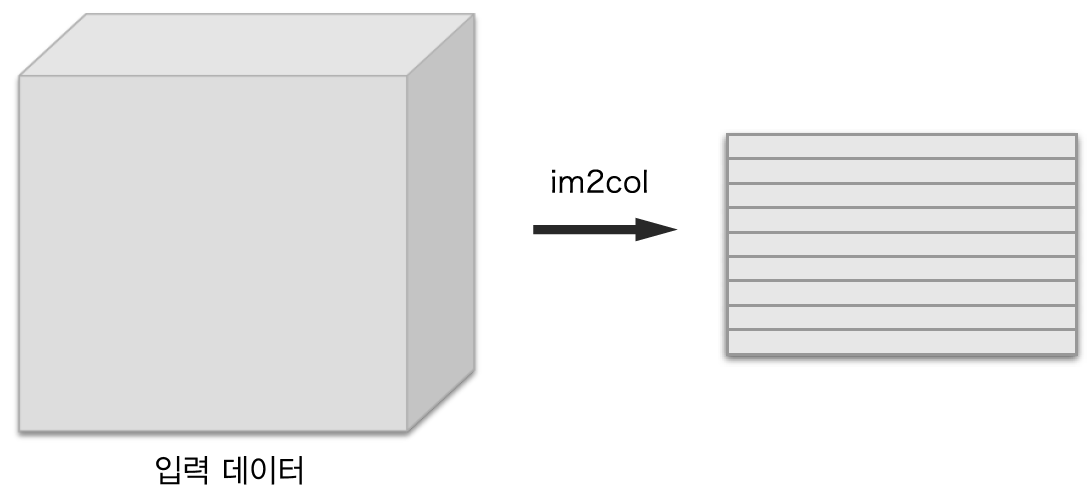

In [57]:
Image("./deep_learning_images/fig 7-17.png", width=400, height=400) # 그림 7-17

구체적으로는 아래 그림과 같이 입력 데이터에서 필터를 적용하는 영역(3차원 블록)을 한줄로 늘어놓는다. 이렇게 필터를 적용하는 모든 영역에서 수행하는 것이 im2col이다.

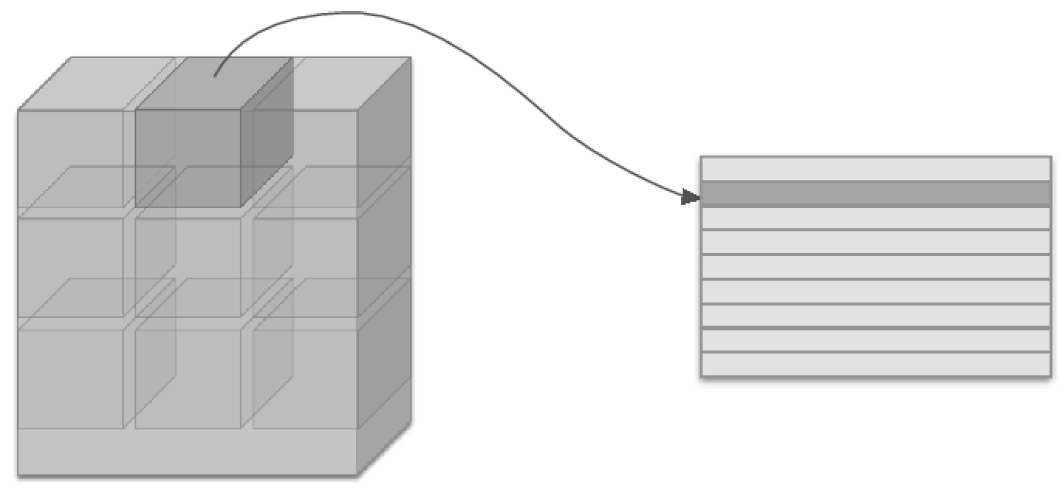

In [58]:
Image("./deep_learning_images/fig 7-18.png", width=400, height=400) # 그림 7-18

im2col로 입력 데이터를 전개한 다음에는 합성곱 계층의 필터(가중치)를 1열로 전개하고, 아래의 그림처럼 두 행렬의 내적을 계산하면 된다.

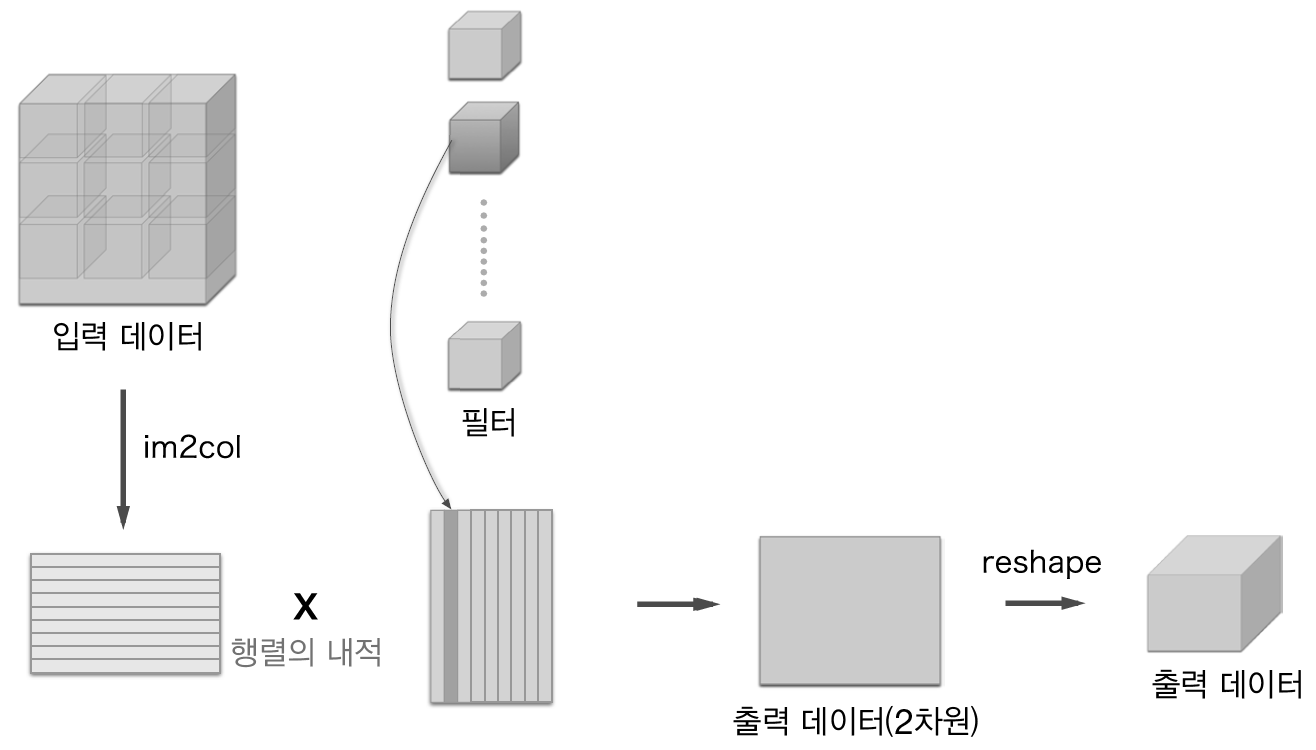

In [60]:
Image("./deep_learning_images/fig 7-19.png", width=500, height=500) # 그림 7-19

im2col 방식으로 출력한 결과는 2차원 행렬이다. CNN은 데이터를 3차원 배열로 저장하므로 2차원인 출력 데이터를 4차원으로 변형한다.

### 7.4.3 합성곱 계층 구현하기

im2col(input_data, filter_h, filter_w, stride=1, pad=0)
- input_data - (데이터 수, 채널 수, 높이, 너비)의 4차원 배열로 이뤄진 입력 데이터
- filter_h - 필터의 높이
- filter_w - 필터의 너비
- stride - 스트라이드
- pad - 패딩

In [66]:
import sys, os
sys.path.append('../deep_learning_from_scratch_org/deep-learning-from-scratch/')
from common.util import im2col

In [67]:
x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)

In [69]:
col1 = im2col(x1, 5, 5, stride=1, pad=0)

In [79]:
print (col1.shape)

(9, 75)


In [80]:
x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개

In [81]:
col2 = im2col(x2, 5, 5, stride=1, pad=0)

In [82]:
print(col2.shape)

(90, 75)


두 경우 모두 2번째 차원의 원소는 75개이며, 이 값은 필터의 원소 수와 같다. (채널 3개, 5 $\times$ 5 데이터)<br>
배치 크기가 1일 때는 im2col의 결과의 크기가 (9, 75), 10일때는 (90, 75)인 데이터가 저장된다.

합성곱 계층(Convolution) 클래스로 구현

In [89]:
col2.reshape(3, 2250)

array([[ 0.80078517,  0.89571427,  0.62420837, ...,  0.9645819 ,
         0.3947508 ,  0.31073214],
       [ 0.08309097,  0.64705102,  0.09103439, ...,  0.82676738,
         0.51560691,  0.28994433],
       [ 0.72067023,  0.47750344,  0.40578864, ...,  0.05368819,
         0.20500538,  0.25461655]])

In [91]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

합성곱 계층은 필터(가중치), 편향, 스트라이드, 패딩을 인수로 받아 초기화한다. 여기서 필터는 (FN, C, FH, FW)의 4차원 형상이다. 여기서 FN은 필터 개수, C는 채널, FH는 필터 높이, FW는 필터 너비이다.

입력 데이터를 im2col로 전개하고 필터도 reshape을 사용해 2차원 배열로 전개한다. 그리고 이렇게 전개한 두 행렬의 내적을 구한다.
<br>필터를 전개하는 부분은 각 필터 블록을 1줄로 펼쳐 세운다.
<br>reshape에 -1을 지정하여서 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 적절히 묶어준다.



가령 (10, 3, 5, 5)형상을 한 다차원 배열 W의 원소 수는 750일텐데, 이 배열에 (10,-1)을 reshape하면 750개의 원소를 10묶음으로, 즉 형상이 (10, 75)인 배열로 만들어준다.

마지막으로 출력 데이터를 적절한 형상을 바꾸어 준다. transpose함수는 다차원 배열의 축 순서를 바꿔주는 함수이다.

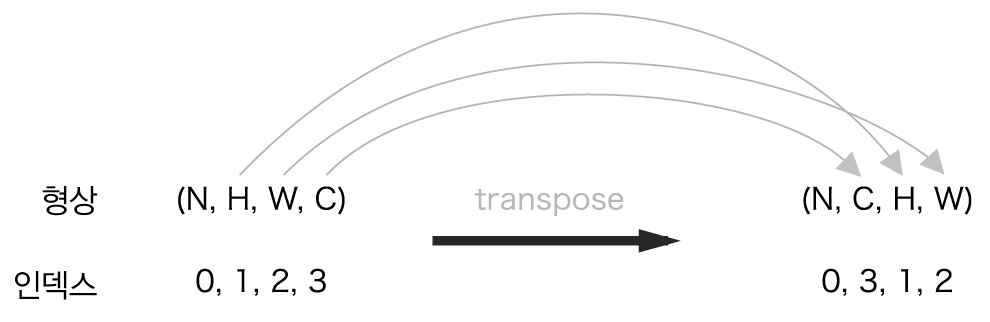

In [92]:
Image("./deep_learning_images/fig 7-20.png", width=400, height=400) # 그림 7-20

### 7.4.4 풀링 계층 구현하기

아래 그림과 같이 풀링 적용 영역을 채널마다 독립적으로 전개한다.

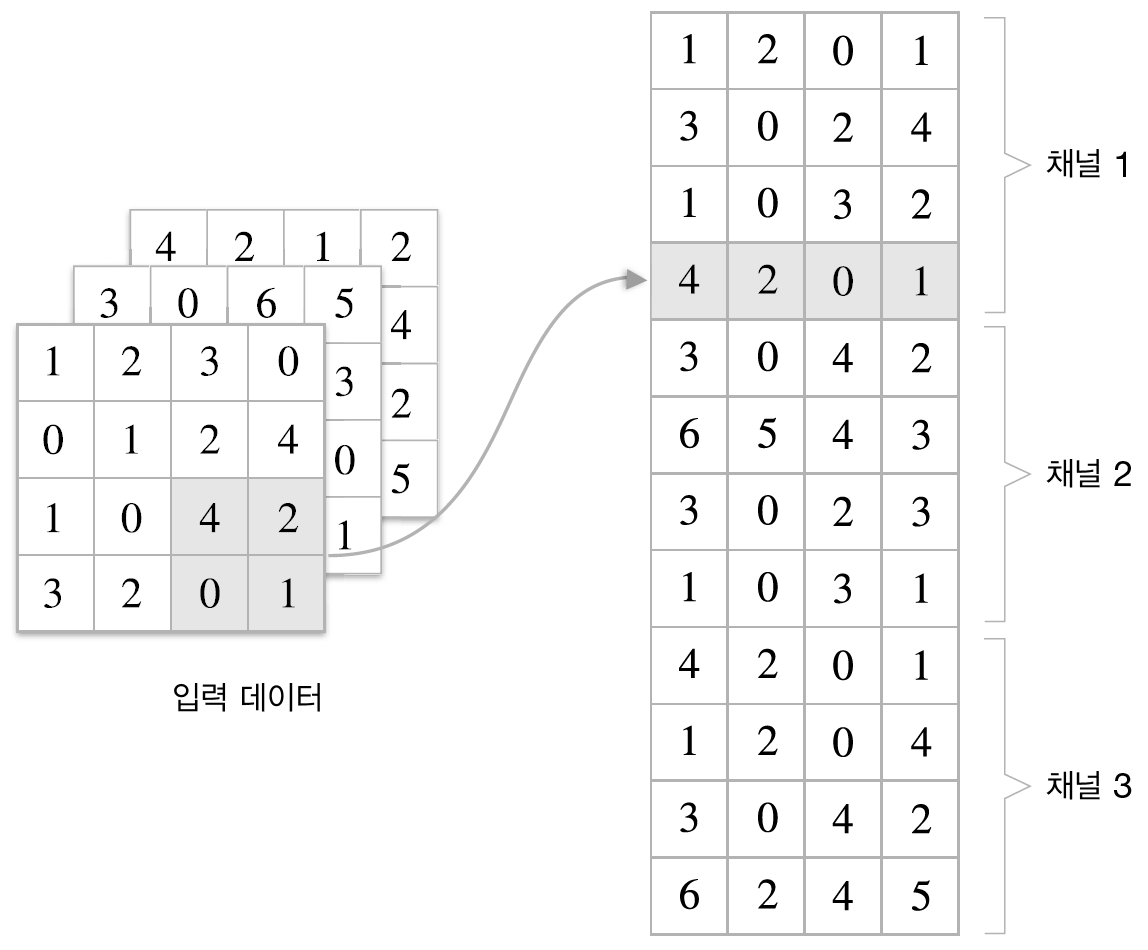

In [93]:
Image("./deep_learning_images/fig 7-21.png", width=400, height=400) # 그림 7-21

이렇게 전개한 후, 전개한 행렬에서 최댓값을 구하고 적절한 형상으로 성향하면 된다.

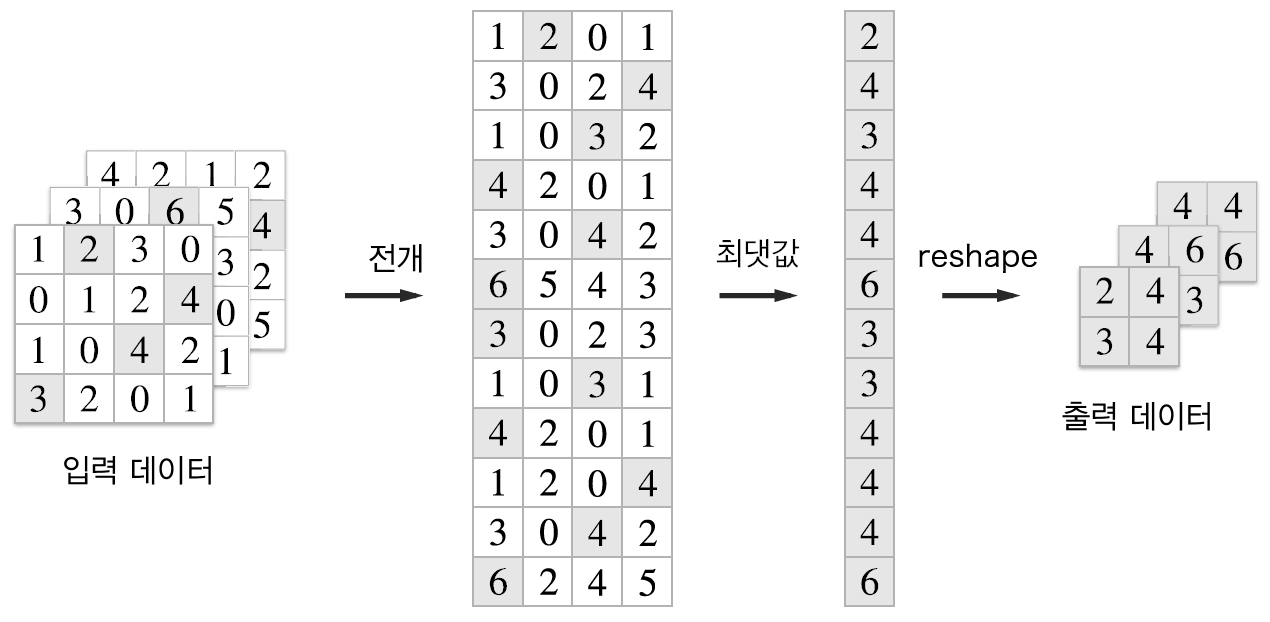

In [95]:
Image("./deep_learning_images/fig 7-22.png", width=500, height=500) # 그림 7-22

풀링 구현하기

In [97]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_h) / self.stride)
        
        # 전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        # 최댓값(2)
        out = np.max(col, axis=1)
        
        # 성형(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

1. 입력 데이터를 전개한다.
2. 행렬 최댓값을 구한다.
3. 적절한 모양으로 성형한다.

**NOTE\_** 최댓값 계산에서 np.max 메서드를 사용할 수 있다. np.max는 인수로 축(axis)를 지정할 수 있는데, 이 인수로 지정한 축마다 최댓값을 구할 수 있다. 가령 np.max(x, axis=1)과 같이 쓰면 입력 x의 1번째 차원의 축마다 최댓값을 구한다.

In [111]:
np.array([[1,2,3],[4,5,6]]).shape

(2, 3)

In [110]:
np.array([[1,20,3],[4,5,6]])

array([[ 1, 20,  3],
       [ 4,  5,  6]])

In [109]:
np.max(np.array([[1,20,3],[4,5,6]]), axis=1)

array([20,  6])

## 7.5 CNN 구현하기

합성곱 계층과 풀링 계층을 구현했으니, 이들 계층을 조합하여 손글씨 숫자를 인식하는 CNN을 조립한다.

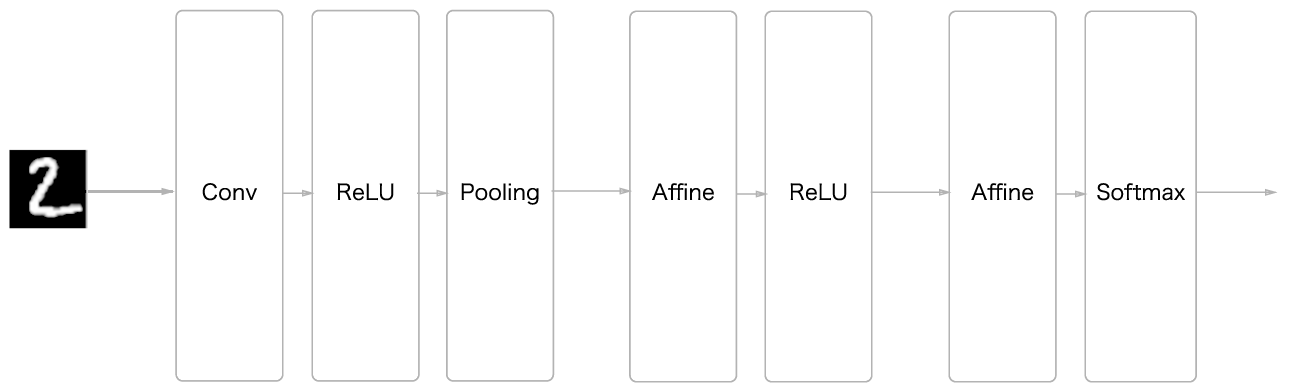

In [112]:
Image("./deep_learning_images/fig 7-23.png", width=500, height=500) # 그림 7-23